In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///C:/Users/Piotrek/Documents/Inzynierka/csgo-analysis/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import shap
import os
import shutil
import math

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, GRU, Dense, Masking, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Wczytanie danych

In [3]:
def select_feat():
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return columns

In [4]:
df = pd.read_parquet('data/ESTA_states_prepared.parquet', columns=select_feat() + ["winningSideCT", 'demoId', 'roundNum'])
df

,seconds,ctAlivePlayers,ctEqVal,tAlivePlayers,tEqVal,ct_armor,t_armor,ct_hp,t_hp,ct_hasHelmet,...,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted,winningSideCT,demoId,roundNum
0,0.007874,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,0,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
1,0.511811,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,0,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
2,1.015748,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,0,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
3,1.519685,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,0,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
4,2.023622,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,0,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464293,81.464567,3,26800,1,24300,290,94,233,74,3,...,0,0,0,1,0,0,1,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464294,81.968504,3,26800,1,24300,290,94,233,74,3,...,0,0,0,1,0,0,1,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464295,82.472441,3,26800,1,24300,286,94,206,74,3,...,0,0,0,1,0,0,1,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464296,82.976378,2,26800,1,24300,194,94,159,74,2,...,0,0,0,1,0,0,1,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464298 entries, 0 to 7464297
Columns: 102 entries, seconds to roundNum
dtypes: float64(17), int32(7), int64(67), object(1), uint8(10)
memory usage: 5.0+ GB


## Podział

In [6]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = list(groupped.indices.keys())
demo_round = pd.DataFrame.from_records(demo_indexes, columns=['demoId', 'roundNum'])
demo_round

,demoId,roundNum
0,0013db25-4444-452b-980b-7702dc6fb810,1
1,0013db25-4444-452b-980b-7702dc6fb810,2
2,0013db25-4444-452b-980b-7702dc6fb810,3
3,0013db25-4444-452b-980b-7702dc6fb810,4
4,0013db25-4444-452b-980b-7702dc6fb810,5
...,...,...
41069,ff910f54-0bed-4fdf-afa8-b481be09a788,22
41070,ff910f54-0bed-4fdf-afa8-b481be09a788,23
41071,ff910f54-0bed-4fdf-afa8-b481be09a788,24
41072,ff910f54-0bed-4fdf-afa8-b481be09a788,25


In [7]:
demo_round_train, demo_round_test = train_test_split(demo_round, test_size=0.2, random_state=1)
demo_round_train, demo_round_val = train_test_split(demo_round_train, test_size=0.125, random_state=1) # 0.125 x 0.8 = 0.1
demo_round_train.shape, demo_round_val.shape, demo_round_test.shape

((28751, 2), (4108, 2), (8215, 2))

In [8]:
df_train = df.merge(demo_round_train, on=['demoId', 'roundNum'])
df_val = df.merge(demo_round_val, on=['demoId', 'roundNum'])
df_test = df.merge(demo_round_test, on=['demoId', 'roundNum'])
df_train.shape, df_val.shape, df_test.shape

((5219419, 102), (746248, 102), (1498631, 102))

In [9]:
def generate_indices(data, lookback):
    grouped = data.groupby(['demoId', 'roundNum'])
    dict_gr = grouped.indices
    for key, val in dict_gr.items():
        dict_gr[key] = np.min(val),  np.max(val)
    
    indices = np.zeros((len(dict_gr), lookback), dtype=np.int32)
    for index, key in enumerate(dict_gr):
        minimum, maximum = dict_gr[key]
        i = random.randint(minimum, maximum)
        if i - minimum < lookback:
            indices[index] = np.hstack((np.repeat(-1, lookback - (i + 1 - minimum)), np.arange(minimum, i + 1, dtype=np.int32)))
        else:
            indices[index] = np.arange(i + 1 - lookback, i + 1, dtype=np.int32)
    return indices

In [10]:
lookback = 20
train_indexes = generate_indices(df_train, lookback)
valid_indexes = generate_indices(df_val, lookback)
test_indexes = generate_indices(df_test, lookback)
train_indexes.size * train_indexes.itemsize / 1_000_000, valid_indexes.size * valid_indexes.itemsize / 1_000_000 , test_indexes.size * test_indexes.itemsize / 1_000_000

(2.30008, 0.32864, 0.6572)

In [12]:
y_train, y_valid, y_test = df_train['winningSideCT'], df_val['winningSideCT'], df_test['winningSideCT']
norm_train = df_train.drop(['demoId', 'roundNum', 'winningSideCT'], axis='columns')
norm_valid = df_val.drop(['demoId', 'roundNum', 'winningSideCT'], axis='columns')
norm_test = df_test.drop(['demoId', 'roundNum', 'winningSideCT'], axis='columns')
cols = norm_train.columns.tolist()
del df_train, df_val, df_test
scaler = StandardScaler()
norm_train = scaler.fit_transform(norm_train)
norm_valid = scaler.transform(norm_valid)
norm_test = scaler.transform(norm_test)

In [13]:
class CSGOsequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, indices, shuffle):
        self.x, self.y = x_set, y_set
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return math.ceil(self.indices.shape[0] / self.batch_size)
                         
    def __getitem__(self, idx):
        batch_x = [np.array([np.zeros(self.x.shape[-1]) if val < 0 else self.x[val] 
                   for val in index])
                       for index in self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices[idx * self.batch_size : (idx + 1) * self.batch_size, -1]]
        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [14]:
train_seq = CSGOsequence(norm_train, y_train.values, 2048, train_indexes, shuffle=True)
valid_seq = CSGOsequence(norm_valid, y_valid.values, 2048, valid_indexes, shuffle=False)
test_seq = CSGOsequence(norm_test, y_test.values, 2048, test_indexes, shuffle=False)

In [15]:
os.makedirs("model_deep", exist_ok=True)

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=30,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/rnn.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/rnn_log.csv", separator=',', append=True
)

In [17]:
model = Sequential()
model.add(InputLayer(input_shape=(lookback, norm_train.shape[-1])))
model.add(Masking(mask_value=0.))
model.add(GRU(256, kernel_regularizer='l2', recurrent_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2', dropout=0.2))
model.add(Dense(128, activation='relu', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(train_seq,
                    epochs=200,
                    validation_data=valid_seq,
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/200
15/15 [==============================] - 5s 161ms/step - loss: 5.7944 - binary_accuracy: 0.7258 - auc: 0.8200 - val_loss: 4.4080 - val_binary_accuracy: 0.7819 - val_auc: 0.8762


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 2/200
15/15 [==============================] - 1s 63ms/step - loss: 3.6366 - binary_accuracy: 0.7741 - auc: 0.8676 - val_loss: 2.7466 - val_binary_accuracy: 0.7880 - val_auc: 0.8791


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 3/200
15/15 [==============================] - 1s 69ms/step - loss: 2.2999 - binary_accuracy: 0.7775 - auc: 0.8706 - val_loss: 1.7910 - val_binary_accuracy: 0.7846 - val_auc: 0.8794


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 4/200
15/15 [==============================] - 1s 65ms/step - loss: 1.5273 - binary_accuracy: 0.7758 - auc: 0.8691 - val_loss: 1.2509 - val_binary_accuracy: 0.7836 - val_auc: 0.8779


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 5/200
15/15 [==============================] - 1s 69ms/step - loss: 1.1026 - binary_accuracy: 0.7789 - auc: 0.8717 - val_loss: 0.9437 - val_binary_accuracy: 0.7802 - val_auc: 0.8773


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 6/200
15/15 [==============================] - 1s 68ms/step - loss: 0.8665 - binary_accuracy: 0.7774 - auc: 0.8714 - val_loss: 0.7666 - val_binary_accuracy: 0.7860 - val_auc: 0.8804


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 7/200
15/15 [==============================] - 1s 66ms/step - loss: 0.7279 - binary_accuracy: 0.7765 - auc: 0.8713 - val_loss: 0.6660 - val_binary_accuracy: 0.7819 - val_auc: 0.8789


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 8/200
15/15 [==============================] - 1s 69ms/step - loss: 0.6467 - binary_accuracy: 0.7722 - auc: 0.8687 - val_loss: 0.6086 - val_binary_accuracy: 0.7863 - val_auc: 0.8797


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 9/200
15/15 [==============================] - 1s 68ms/step - loss: 0.6004 - binary_accuracy: 0.7750 - auc: 0.8713 - val_loss: 0.5781 - val_binary_accuracy: 0.7831 - val_auc: 0.8771


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 10/200
15/15 [==============================] - 1s 67ms/step - loss: 0.5775 - binary_accuracy: 0.7738 - auc: 0.8682 - val_loss: 0.5563 - val_binary_accuracy: 0.7882 - val_auc: 0.8802


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 11/200
15/15 [==============================] - 1s 70ms/step - loss: 0.5592 - binary_accuracy: 0.7749 - auc: 0.8704 - val_loss: 0.5433 - val_binary_accuracy: 0.7843 - val_auc: 0.8797


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 12/200
15/15 [==============================] - 1s 69ms/step - loss: 0.5484 - binary_accuracy: 0.7768 - auc: 0.8717 - val_loss: 0.5381 - val_binary_accuracy: 0.7853 - val_auc: 0.8779


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 13/200
15/15 [==============================] - 1s 68ms/step - loss: 0.5438 - binary_accuracy: 0.7754 - auc: 0.8714 - val_loss: 0.5307 - val_binary_accuracy: 0.7841 - val_auc: 0.8821


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 14/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5422 - binary_accuracy: 0.7749 - auc: 0.8696 - val_loss: 0.5305 - val_binary_accuracy: 0.7804 - val_auc: 0.8796


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 15/200
15/15 [==============================] - 1s 69ms/step - loss: 0.5393 - binary_accuracy: 0.7725 - auc: 0.8703 - val_loss: 0.5281 - val_binary_accuracy: 0.7836 - val_auc: 0.8803


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 16/200
15/15 [==============================] - 1s 66ms/step - loss: 0.5368 - binary_accuracy: 0.7770 - auc: 0.8716 - val_loss: 0.5335 - val_binary_accuracy: 0.7831 - val_auc: 0.8749
Epoch 17/200
15/15 [==============================] - 1s 58ms/step - loss: 0.5388 - binary_accuracy: 0.7734 - auc: 0.8689 - val_loss: 0.5272 - val_binary_accuracy: 0.7833 - val_auc: 0.8800


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 18/200
15/15 [==============================] - 1s 61ms/step - loss: 0.5353 - binary_accuracy: 0.7741 - auc: 0.8717 - val_loss: 0.5247 - val_binary_accuracy: 0.7882 - val_auc: 0.8809


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 19/200
15/15 [==============================] - 1s 69ms/step - loss: 0.5358 - binary_accuracy: 0.7766 - auc: 0.8712 - val_loss: 0.5256 - val_binary_accuracy: 0.7858 - val_auc: 0.8810
Epoch 20/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5348 - binary_accuracy: 0.7772 - auc: 0.8720 - val_loss: 0.5250 - val_binary_accuracy: 0.7887 - val_auc: 0.8814
Epoch 21/200
15/15 [==============================] - 1s 56ms/step - loss: 0.5359 - binary_accuracy: 0.7741 - auc: 0.8708 - val_loss: 0.5262 - val_binary_accuracy: 0.7865 - val_auc: 0.8793
Epoch 22/200
15/15 [==============================] - 1s 57ms/step - loss: 0.5339 - binary_accuracy: 0.7767 - auc: 0.8718 - val_loss: 0.5262 - val_binary_accuracy: 0.7863 - val_auc: 0.8797
Epoch 23/200
15/15 [==============================] - 1s 58ms/step - loss: 0.5335 - binary_accuracy: 0.7779 - auc: 0.8728 - val_loss: 0.5237 - val_binary_accuracy: 0.7889 - val_auc: 0.8817


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 24/200
15/15 [==============================] - 1s 72ms/step - loss: 0.5340 - binary_accuracy: 0.7769 - auc: 0.8726 - val_loss: 0.5265 - val_binary_accuracy: 0.7826 - val_auc: 0.8791
Epoch 25/200
15/15 [==============================] - 1s 61ms/step - loss: 0.5348 - binary_accuracy: 0.7764 - auc: 0.8715 - val_loss: 0.5259 - val_binary_accuracy: 0.7872 - val_auc: 0.8801
Epoch 26/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5331 - binary_accuracy: 0.7775 - auc: 0.8726 - val_loss: 0.5251 - val_binary_accuracy: 0.7860 - val_auc: 0.8801
Epoch 27/200
15/15 [==============================] - 1s 57ms/step - loss: 0.5330 - binary_accuracy: 0.7773 - auc: 0.8726 - val_loss: 0.5244 - val_binary_accuracy: 0.7863 - val_auc: 0.8805
Epoch 28/200
15/15 [==============================] - 1s 58ms/step - loss: 0.5332 - binary_accuracy: 0.7789 - auc: 0.8726 - val_loss: 0.5237 - val_binary_accuracy: 0.7843 - val_auc: 0.8815
Epoch 29/200
15/15 [==============================] - 1

INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 33/200
15/15 [==============================] - 1s 72ms/step - loss: 0.5328 - binary_accuracy: 0.7769 - auc: 0.8726 - val_loss: 0.5240 - val_binary_accuracy: 0.7897 - val_auc: 0.8818
Epoch 34/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5337 - binary_accuracy: 0.7780 - auc: 0.8725 - val_loss: 0.5237 - val_binary_accuracy: 0.7858 - val_auc: 0.8820
Epoch 35/200
15/15 [==============================] - 1s 57ms/step - loss: 0.5329 - binary_accuracy: 0.7779 - auc: 0.8729 - val_loss: 0.5238 - val_binary_accuracy: 0.7851 - val_auc: 0.8807
Epoch 36/200
15/15 [==============================] - 1s 60ms/step - loss: 0.5333 - binary_accuracy: 0.7761 - auc: 0.8722 - val_loss: 0.5239 - val_binary_accuracy: 0.7863 - val_auc: 0.8807
Epoch 37/200
15/15 [==============================] - 1s 58ms/step - loss: 0.5327 - binary_accuracy: 0.7790 - auc: 0.8725 - val_loss: 0.5234 - val_binary_accuracy: 0.7882 - val_auc: 0.8817
Epoch 38/200
15/15 [==============================] - 1

INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 49/200
15/15 [==============================] - 1s 68ms/step - loss: 0.5312 - binary_accuracy: 0.7768 - auc: 0.8737 - val_loss: 0.5224 - val_binary_accuracy: 0.7851 - val_auc: 0.8815


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 50/200
15/15 [==============================] - 1s 71ms/step - loss: 0.5318 - binary_accuracy: 0.7769 - auc: 0.8736 - val_loss: 0.5237 - val_binary_accuracy: 0.7865 - val_auc: 0.8807
Epoch 51/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5333 - binary_accuracy: 0.7756 - auc: 0.8718 - val_loss: 0.5251 - val_binary_accuracy: 0.7904 - val_auc: 0.8809
Epoch 52/200
15/15 [==============================] - 1s 56ms/step - loss: 0.5319 - binary_accuracy: 0.7782 - auc: 0.8732 - val_loss: 0.5220 - val_binary_accuracy: 0.7865 - val_auc: 0.8820


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 53/200
15/15 [==============================] - 1s 68ms/step - loss: 0.5318 - binary_accuracy: 0.7779 - auc: 0.8734 - val_loss: 0.5237 - val_binary_accuracy: 0.7863 - val_auc: 0.8812
Epoch 54/200
15/15 [==============================] - 1s 57ms/step - loss: 0.5338 - binary_accuracy: 0.7767 - auc: 0.8714 - val_loss: 0.5233 - val_binary_accuracy: 0.7875 - val_auc: 0.8815
Epoch 55/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5339 - binary_accuracy: 0.7773 - auc: 0.8720 - val_loss: 0.5228 - val_binary_accuracy: 0.7882 - val_auc: 0.8819
Epoch 56/200
15/15 [==============================] - 1s 60ms/step - loss: 0.5327 - binary_accuracy: 0.7777 - auc: 0.8725 - val_loss: 0.5229 - val_binary_accuracy: 0.7909 - val_auc: 0.8819
Epoch 57/200
15/15 [==============================] - 1s 57ms/step - loss: 0.5343 - binary_accuracy: 0.7761 - auc: 0.8715 - val_loss: 0.5246 - val_binary_accuracy: 0.7821 - val_auc: 0.8807
Epoch 58/200
15/15 [==============================] - 1

INFO:tensorflow:Assets written to: models/model.tf\assets


INFO:tensorflow:Assets written to: models/model.tf\assets


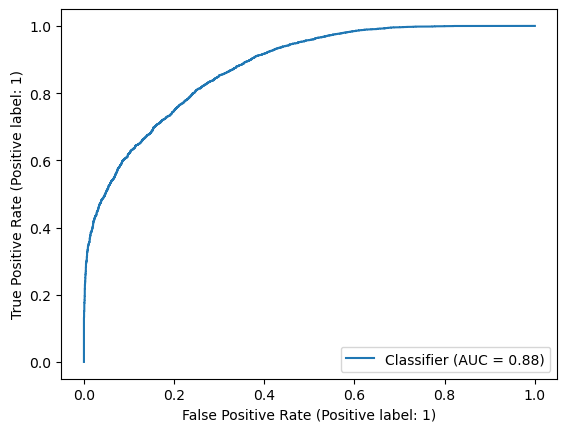

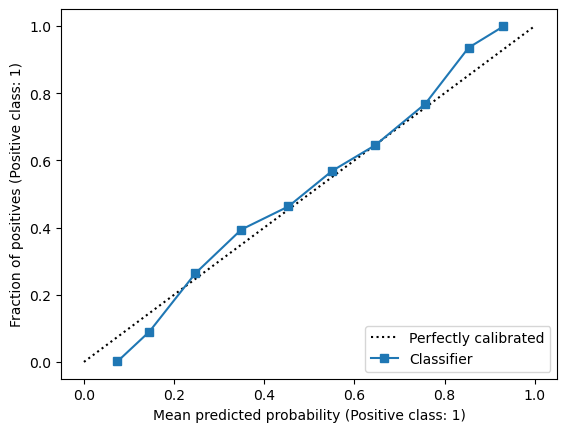

In [19]:
run_name = "RNN - ESTA"
additional_description = "RNN"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)
        mlflow.log_param("Sequence", lookback)

        y_proba = model.predict(test_seq)
        y_true = y_test[test_indexes[:, -1]]
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

# Wiekszy sampling

In [20]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = list(groupped.indices.keys())
demo_round = pd.DataFrame.from_records(demo_indexes, columns=['demoId', 'roundNum'])
demo_round

,demoId,roundNum
0,0013db25-4444-452b-980b-7702dc6fb810,1
1,0013db25-4444-452b-980b-7702dc6fb810,2
2,0013db25-4444-452b-980b-7702dc6fb810,3
3,0013db25-4444-452b-980b-7702dc6fb810,4
4,0013db25-4444-452b-980b-7702dc6fb810,5
...,...,...
41069,ff910f54-0bed-4fdf-afa8-b481be09a788,22
41070,ff910f54-0bed-4fdf-afa8-b481be09a788,23
41071,ff910f54-0bed-4fdf-afa8-b481be09a788,24
41072,ff910f54-0bed-4fdf-afa8-b481be09a788,25


In [21]:
demo_round_train, demo_round_test = train_test_split(demo_round, test_size=0.2, random_state=1)
demo_round_train, demo_round_val = train_test_split(demo_round_train, test_size=0.125, random_state=1) # 0.125 x 0.8 = 0.1
demo_round_train.shape, demo_round_val.shape, demo_round_test.shape

((28751, 2), (4108, 2), (8215, 2))

In [22]:
df_train = df.merge(demo_round_train, on=['demoId', 'roundNum'])
df_val = df.merge(demo_round_val, on=['demoId', 'roundNum'])
df_test = df.merge(demo_round_test, on=['demoId', 'roundNum'])
df_train.shape, df_val.shape, df_test.shape

((5219419, 102), (746248, 102), (1498631, 102))

In [23]:
def generate_indices(data, lookback, how_many=10):
    grouped = data.groupby(['demoId', 'roundNum'])
    dict_gr = grouped.indices
    for key, val in dict_gr.items():
        dict_gr[key] = np.min(val),  np.max(val)
    
    indices = np.zeros((len(dict_gr) * how_many, lookback), dtype=np.int32)
    index = 0
    for key in dict_gr:
        minimum, maximum = dict_gr[key]
        for j in range(how_many):
            i = random.randint(minimum, maximum)
            if i - minimum < lookback:
                indices[index] = np.hstack((np.repeat(-1, lookback - (i + 1 - minimum)), np.arange(minimum, i + 1, dtype=np.int32)))
            else:
                indices[index] = np.arange(i + 1 - lookback, i + 1, dtype=np.int32)
            index += 1
    return indices

In [24]:
lookback = 20
train_indexes = generate_indices(df_train, lookback)
valid_indexes = generate_indices(df_val, lookback)
test_indexes = generate_indices(df_test, lookback)
train_indexes.size * train_indexes.itemsize / 1_000_000, valid_indexes.size * valid_indexes.itemsize / 1_000_000 , test_indexes.size * test_indexes.itemsize / 1_000_000

(23.0008, 3.2864, 6.572)

In [25]:
y_train, y_valid, y_test = df_train['winningSideCT'], df_val['winningSideCT'], df_test['winningSideCT']
norm_train = df_train.drop(['demoId', 'roundNum', 'winningSideCT'], axis='columns')
norm_valid = df_val.drop(['demoId', 'roundNum', 'winningSideCT'], axis='columns')
norm_test = df_test.drop(['demoId', 'roundNum', 'winningSideCT'], axis='columns')
cols = norm_train.columns.tolist()
del df_train, df_val, df_test
scaler = StandardScaler()
norm_train = scaler.fit_transform(norm_train)
norm_valid = scaler.transform(norm_valid)
norm_test = scaler.transform(norm_test)

In [26]:
class CSGOsequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, indices, shuffle):
        self.x, self.y = x_set, y_set
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return math.ceil(self.indices.shape[0] / self.batch_size)
                         
    def __getitem__(self, idx):
        batch_x = [np.array([np.zeros(self.x.shape[-1]) if val < 0 else self.x[val] 
                   for val in index])
                       for index in self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices[idx * self.batch_size : (idx + 1) * self.batch_size, -1]]
        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [27]:
train_seq = CSGOsequence(norm_train, y_train.values, 2048, train_indexes, shuffle=True)
valid_seq = CSGOsequence(norm_valid, y_valid.values, 2048, valid_indexes, shuffle=False)
test_seq = CSGOsequence(norm_test, y_test.values, 2048, test_indexes, shuffle=False)

In [28]:
os.makedirs("model_deep", exist_ok=True)

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=30,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/rnn.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/rnn_log.csv", separator=',', append=True
)

In [31]:
model = Sequential()
model.add(InputLayer(input_shape=(lookback, norm_train.shape[-1])))
model.add(Masking(mask_value=0.))
model.add(GRU(256, kernel_regularizer='l2', recurrent_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2', dropout=0.2))
model.add(Dense(128, activation='relu', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(train_seq,
                    epochs=200,
                    validation_data=valid_seq,
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/200
141/141 [==============================] - 10s 60ms/step - loss: 1.8237 - binary_accuracy: 0.7733 - auc_2: 0.8678 - val_loss: 0.5626 - val_binary_accuracy: 0.7800 - val_auc_2: 0.8774


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 2/200
141/141 [==============================] - 8s 57ms/step - loss: 0.5394 - binary_accuracy: 0.7754 - auc_2: 0.8727 - val_loss: 0.5286 - val_binary_accuracy: 0.7794 - val_auc_2: 0.8773


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 3/200
141/141 [==============================] - 8s 57ms/step - loss: 0.5314 - binary_accuracy: 0.7778 - auc_2: 0.8736 - val_loss: 0.5277 - val_binary_accuracy: 0.7820 - val_auc_2: 0.8775


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 4/200
141/141 [==============================] - 8s 58ms/step - loss: 0.5310 - binary_accuracy: 0.7764 - auc_2: 0.8736 - val_loss: 0.5259 - val_binary_accuracy: 0.7799 - val_auc_2: 0.8786


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 5/200
141/141 [==============================] - 8s 58ms/step - loss: 0.5307 - binary_accuracy: 0.7773 - auc_2: 0.8737 - val_loss: 0.5269 - val_binary_accuracy: 0.7804 - val_auc_2: 0.8781
Epoch 6/200
141/141 [==============================] - 8s 58ms/step - loss: 0.5309 - binary_accuracy: 0.7764 - auc_2: 0.8736 - val_loss: 0.5265 - val_binary_accuracy: 0.7806 - val_auc_2: 0.8784
Epoch 7/200
141/141 [==============================] - 8s 56ms/step - loss: 0.5309 - binary_accuracy: 0.7771 - auc_2: 0.8735 - val_loss: 0.5275 - val_binary_accuracy: 0.7769 - val_auc_2: 0.8770
Epoch 8/200
141/141 [==============================] - 8s 57ms/step - loss: 0.5305 - binary_accuracy: 0.7767 - auc_2: 0.8739 - val_loss: 0.5273 - val_binary_accuracy: 0.7797 - val_auc_2: 0.8774
Epoch 9/200
141/141 [==============================] - 8s 55ms/step - loss: 0.5304 - binary_accuracy: 0.7775 - auc_2: 0.8740 - val_loss: 0.5267 - val_binary_accuracy: 0.7814 - val_auc_2: 0.8783
Epoch 10/200
141/141 [========

INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 11/200
141/141 [==============================] - 8s 55ms/step - loss: 0.5307 - binary_accuracy: 0.7772 - auc_2: 0.8738 - val_loss: 0.5272 - val_binary_accuracy: 0.7811 - val_auc_2: 0.8780
Epoch 12/200
141/141 [==============================] - 8s 54ms/step - loss: 0.5306 - binary_accuracy: 0.7776 - auc_2: 0.8740 - val_loss: 0.5287 - val_binary_accuracy: 0.7809 - val_auc_2: 0.8770
Epoch 13/200
141/141 [==============================] - 8s 55ms/step - loss: 0.5308 - binary_accuracy: 0.7772 - auc_2: 0.8739 - val_loss: 0.5266 - val_binary_accuracy: 0.7811 - val_auc_2: 0.8783
Epoch 14/200
141/141 [==============================] - 7s 52ms/step - loss: 0.5306 - binary_accuracy: 0.7773 - auc_2: 0.8739 - val_loss: 0.5263 - val_binary_accuracy: 0.7816 - val_auc_2: 0.8786
Epoch 15/200
141/141 [==============================] - 8s 55ms/step - loss: 0.5305 - binary_accuracy: 0.7771 - auc_2: 0.8740 - val_loss: 0.5263 - val_binary_accuracy: 0.7824 - val_auc_2: 0.8790
Epoch 16/200
141/141 [===

INFO:tensorflow:Assets written to: models/model.tf\assets


INFO:tensorflow:Assets written to: models/model.tf\assets


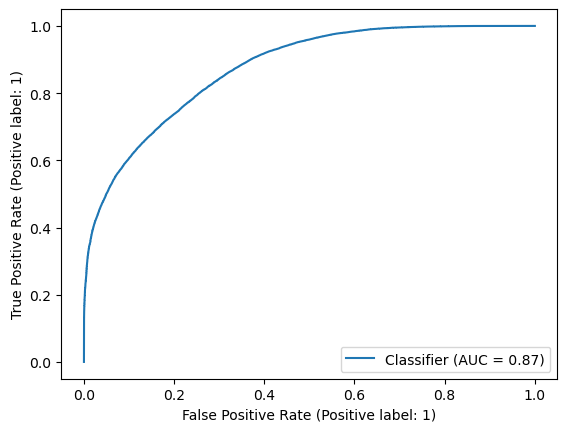

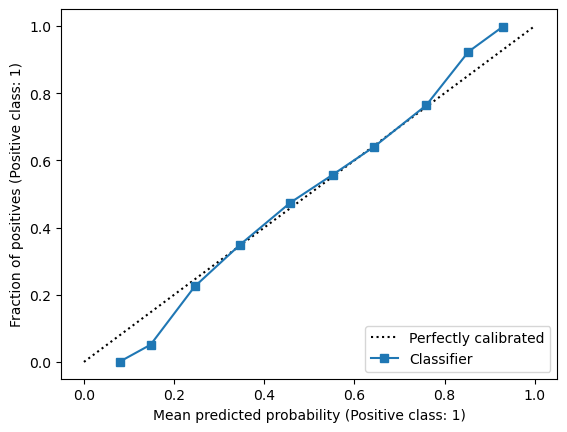

In [32]:
run_name = "RNN - ESTA 10 samples"
additional_description = "RNN"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)
        mlflow.log_param("Sequence", lookback)

        y_proba = model.predict(test_seq)
        y_true = y_test[test_indexes[:, -1]]
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

# All dataset

In [33]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = list(groupped.indices.keys())
demo_round = pd.DataFrame.from_records(demo_indexes, columns=['demoId', 'roundNum'])
demo_round

,demoId,roundNum
0,0013db25-4444-452b-980b-7702dc6fb810,1
1,0013db25-4444-452b-980b-7702dc6fb810,2
2,0013db25-4444-452b-980b-7702dc6fb810,3
3,0013db25-4444-452b-980b-7702dc6fb810,4
4,0013db25-4444-452b-980b-7702dc6fb810,5
...,...,...
41069,ff910f54-0bed-4fdf-afa8-b481be09a788,22
41070,ff910f54-0bed-4fdf-afa8-b481be09a788,23
41071,ff910f54-0bed-4fdf-afa8-b481be09a788,24
41072,ff910f54-0bed-4fdf-afa8-b481be09a788,25


In [34]:
demo_round_train, demo_round_test = train_test_split(demo_round, test_size=0.2, random_state=1)
demo_round_train, demo_round_val = train_test_split(demo_round_train, test_size=0.125, random_state=1) # 0.125 x 0.8 = 0.1
demo_round_train.shape, demo_round_val.shape, demo_round_test.shape

((28751, 2), (4108, 2), (8215, 2))

In [35]:
df_train = df.merge(demo_round_train, on=['demoId', 'roundNum'])
df_val = df.merge(demo_round_val, on=['demoId', 'roundNum'])
df_test = df.merge(demo_round_test, on=['demoId', 'roundNum'])
df_train.shape, df_val.shape, df_test.shape

((5219419, 102), (746248, 102), (1498631, 102))

In [36]:
def generate_indices(data, lookback):
    grouped = data.groupby(['demoId', 'roundNum'])
    dict_gr = grouped.indices
    for key, val in dict_gr.items():
        dict_gr[key] = np.min(val),  np.max(val)
    
    indices = np.zeros((len(data.index), lookback), dtype=np.int32)
    for key in dict_gr:
        minimum, maximum = dict_gr[key]
        for i in range(minimum, maximum + 1):
            if i - minimum < lookback:
                indices[i] = np.hstack((np.repeat(-1, lookback - (i + 1 - minimum)), np.arange(minimum, i + 1, dtype=np.int32)))
            else:
                indices[i] = np.arange(i + 1 - lookback, i + 1, dtype=np.int32)
    return indices

In [37]:
lookback = 20
train_indexes = generate_indices(df_train, lookback)
valid_indexes = generate_indices(df_val, lookback)
test_indexes = generate_indices(df_test, lookback)
train_indexes.size * train_indexes.itemsize / 1_000_000, valid_indexes.size * valid_indexes.itemsize / 1_000_000 , test_indexes.size * test_indexes.itemsize / 1_000_000

(417.55352, 59.69984, 119.89048)

In [38]:
y_train, y_valid, y_test = df_train['winningSideCT'], df_val['winningSideCT'], df_test['winningSideCT']
norm_train = df_train.drop(['demoId', 'roundNum', 'winningSideCT'], axis='columns')
norm_valid = df_val.drop(['demoId', 'roundNum', 'winningSideCT'], axis='columns')
norm_test = df_test.drop(['demoId', 'roundNum', 'winningSideCT'], axis='columns')
cols = norm_train.columns.tolist()
del df_train, df_val, df_test
scaler = StandardScaler()
norm_train = scaler.fit_transform(norm_train)
norm_valid = scaler.transform(norm_valid)
norm_test = scaler.transform(norm_test)

In [39]:
class CSGOsequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, indices, shuffle):
        self.x, self.y = x_set, y_set
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return math.ceil(self.indices.shape[0] / self.batch_size)
                         
    def __getitem__(self, idx):
        batch_x = [np.array([np.zeros(self.x.shape[-1]) if val < 0 else self.x[val] 
                   for val in index])
                       for index in self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices[idx * self.batch_size : (idx + 1) * self.batch_size, -1]]
        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [41]:
train_seq = CSGOsequence(norm_train, y_train.values, 10000, train_indexes, shuffle=True)
valid_seq = CSGOsequence(norm_valid, y_valid.values, 10000, valid_indexes, shuffle=False)
test_seq = CSGOsequence(norm_test, y_test.values, 10000, test_indexes, shuffle=False)

In [42]:
os.makedirs("model_deep", exist_ok=True)

In [45]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/rnn.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/rnn_log.csv", separator=',', append=True
)

In [46]:
model = Sequential()
model.add(InputLayer(input_shape=(lookback, norm_train.shape[-1])))
model.add(Masking(mask_value=0.))
model.add(GRU(256, kernel_regularizer='l2', recurrent_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2', dropout=0.2))
model.add(Dense(128, activation='relu', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(train_seq,
                    epochs=200,
                    validation_data=valid_seq,
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/200
522/522 [==============================] - 103s 195ms/step - loss: 0.8969 - binary_accuracy: 0.7578 - auc_4: 0.8559 - val_loss: 0.5459 - val_binary_accuracy: 0.7607 - val_auc_4: 0.8621


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 2/200
522/522 [==============================] - 102s 195ms/step - loss: 0.5501 - binary_accuracy: 0.7587 - auc_4: 0.8575 - val_loss: 0.5468 - val_binary_accuracy: 0.7599 - val_auc_4: 0.8612
Epoch 3/200
522/522 [==============================] - 101s 193ms/step - loss: 0.5500 - binary_accuracy: 0.7588 - auc_4: 0.8576 - val_loss: 0.5462 - val_binary_accuracy: 0.7599 - val_auc_4: 0.8616
Epoch 4/200
522/522 [==============================] - 100s 191ms/step - loss: 0.5500 - binary_accuracy: 0.7591 - auc_4: 0.8577 - val_loss: 0.5459 - val_binary_accuracy: 0.7612 - val_auc_4: 0.8618
Epoch 5/200
522/522 [==============================] - 100s 191ms/step - loss: 0.5500 - binary_accuracy: 0.7589 - auc_4: 0.8577 - val_loss: 0.5464 - val_binary_accuracy: 0.7594 - val_auc_4: 0.8612
Epoch 6/200
522/522 [==============================] - 99s 189ms/step - loss: 0.5500 - binary_accuracy: 0.7591 - auc_4: 0.8577 - val_loss: 0.5467 - val_binary_accuracy: 0.7602 - val_auc_4: 0.8616
Epoch 7/200
522/

INFO:tensorflow:Assets written to: models/model.tf\assets


INFO:tensorflow:Assets written to: models/model.tf\assets


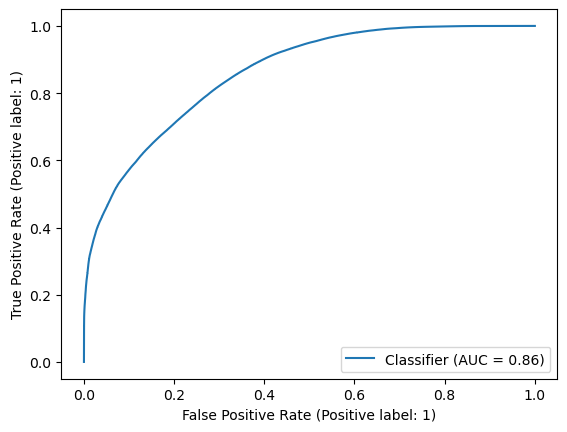

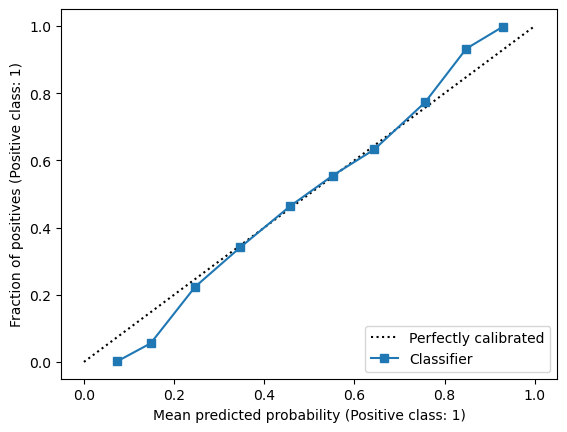

In [47]:
run_name = "RNN - ESTA All Dataset"
additional_description = "RNN"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)
        mlflow.log_param("Sequence", lookback)

        y_proba = model.predict(test_seq)
        y_true = y_test[test_indexes[:, -1]]
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")